In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import time

In [3]:
import gym
import stage.envs
from stage.tasks.kuka import KukaPETS
from stage.utils.nn import use_gpu

In [4]:
savepath = parentdir + '/data/kuka/'

In [38]:
x = np.arange(0, 1, 0.01)
y = np.exp(-20*x)

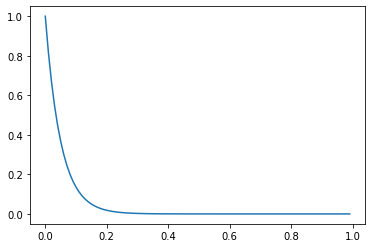

In [39]:
plt.plot(x, y)

In [7]:
from stage.utils.nn import truncated_normal
h = 100
b = 3
noise_iid = truncated_normal((b,h), torch.zeros(h), torch.ones(1))
noise = torch.zeros_like(noise_iid)
a = 0.9
noise[:, 0] = a * noise_iid[:, 0]
for t in range(1, h):
    noise[:, t] = a * noise[:, t-1] + (1-a)*noise_iid[:, t]

In [8]:
mean = torch.ones(4)

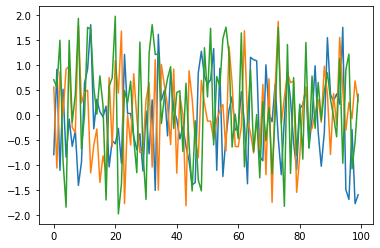

In [9]:
plt.plot(noise_iid.T.detach().cpu().numpy())

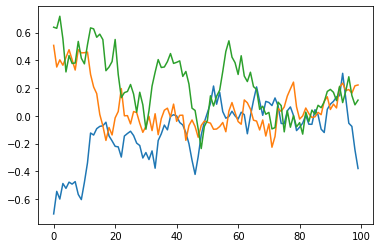

In [10]:
plt.plot(noise.T.detach().cpu().numpy())

In [11]:
import torch.nn.functional as F
na = 3
pop_size = 3
horizon = 5
costs = torch.rand(pop_size, horizon)
samples = torch.rand(pop_size, horizon*na)

In [13]:
P = F.softmax(-(costs), dim=0)

In [14]:
A = P.view(pop_size, horizon, 1) * (samples.view(pop_size, horizon, na))
A = A.view(pop_size, -1)
new_mean = torch.sum(A, dim=0)
samples_centered = samples - new_mean

In [17]:
new_mean

tensor([0.4213, 0.2672, 0.5301, 0.4482, 0.3056, 0.6698, 0.4913, 0.2995, 0.4402,
        0.4322, 0.5386, 0.1036, 0.4755, 0.7046, 0.6308])

In [21]:
A = P.view(pop_size, horizon, 1) * (samples.view(pop_size, horizon, na))
new_mean = A.sum(dim=0)
samples_centered = samples.view(pop_size, horizon, na) - new_mean
new_mean = new_mean.view(horizon*na)

In [23]:
new_mean

tensor([0.4213, 0.2672, 0.5301, 0.4482, 0.3056, 0.6698, 0.4913, 0.2995, 0.4402,
        0.4322, 0.5386, 0.1036, 0.4755, 0.7046, 0.6308])

In [ ]:
B = P.view(pop_size, horizon, 1) * samples_centered 

In [ ]:
V = B.view(pop_size, -1)

In [ ]:
samples_centered = samples_centered.view(pop_size, -1)

In [ ]:
torch.mm(V.T, samples_centered)

In [ ]:
new_mean = torch.sum(P * elites, dim=0)
elites_centered = elites.add(-new_mean) 
new_var = torch.diag(torch.mm((P * elites_centered).T, elites_centered))

In [ ]:
def flip(x, dim):
    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.view(-1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[:, getattr(torch.arange(x.size(1)-1, 
                      -1, -1), ('cpu','cuda')[x.is_cuda])().long(), :]
    return x.view(xsize)

In [ ]:
costs_flipped = flip(costs, dim=1)

In [ ]:
costs_to_go = torch.zeros_like(costs)
costs_to_go[:, 0] = costs_flipped[:, 0]
for k in range(1, 5):
    costs_to_go[:, k] = costs_flipped[:, k] + costs_to_go[:, k - 1]
costs_to_go = flip(costs_to_go, dim=1)

In [ ]:
cmin = torch.min(costs_to_go, dim=0)[0]
cmax = torch.max(costs_to_go, dim=0)[0]

In [ ]:
costs_to_go = (costs_to_go - cmin)/(cmax - cmin + 1e-6)

In [ ]:
# data_train = np.load(savepath+'data_pd_reg.npy')
# kuka = KukaPETS(render=True, 
#                 action_parameterization='pd')
# kuka.visualize_training_data(data_train, it_begin=0)
# q = kuka.env.step_cost.desired.detach().cpu().numpy()
# v = np.zeros(7)
# kuka.env.set_state(q, v)

In [ ]:
# kuka.env.close()